In [1]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install pyttsx3
!pip install gTTS
!pip install pydub
!pip install playsound

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-jhajelfh
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-jhajelfh
  Resolved https://github.com/huggingface/transformers.git to commit ff841900e45763114d2417fb24ce29d950c6c956
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.40.0.dev0-py3-none-any.whl size=8804612 sha256=319826c3fceb017852c0fe2fb89a4734042eb7ab3b18032c133cad9a3c1d3260
  Stored in directory: /tmp/pip-ephem-wheel-cache-sxe1ao3l/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
  Preparing metadata (setup.

In [2]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [3]:
import requests
import pyttsx3
from gtts import gTTS
from IPython.display import Audio
from pydub import AudioSegment
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [4]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [7]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)

  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


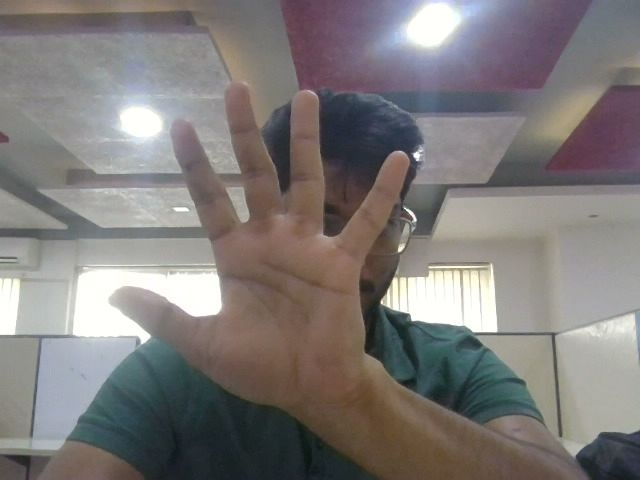

In [8]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

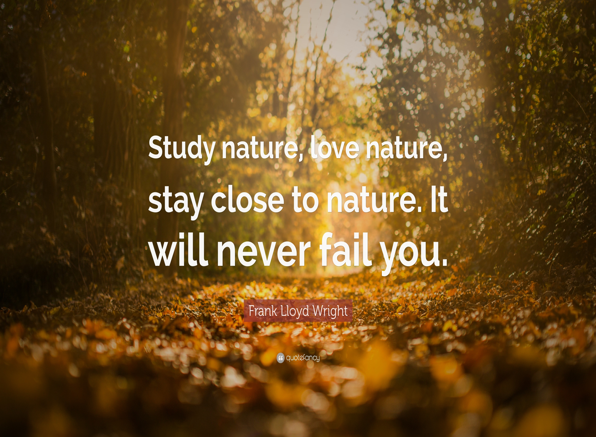

In [20]:
from PIL import Image

# Open the image from the specified path
image = Image.open("/content/photo1.jpg").convert('RGB')

# Resize the image
image = image.resize((596, 437))

# Display the image (assuming you have a display function like `display`)
display(image)


In [10]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch


processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [21]:
inputs = processor(image, return_tensors="pt", dtype=torch.float32).to(device)  # Specify float32 explicitly

generated_ids = model.generate(**inputs, max_new_tokens=40)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0].strip()
print(generated_text)

with open("my_saved_text.txt", "a") as output_file:
    # Write the generated text to the file
    text_with_newline = generated_text + "\n"

    output_file.write(text_with_newline)

    speech = gTTS(text=generated_text, lang='en')  # Change 'en' for other languages

# Save the audio to a file
speech.save("generated_text.mp3")

#Play the generated audio
from playsound import playsound
Audio("generated_text.mp3")


Both `max_new_tokens` (=40) and `max_length`(=52) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


study nature, love nature, stay close to nature it will never fail you quote by peter gabrielle</s>I'm not sure if this is a good thing or a bad thing.


In [22]:
prompt = "this is an image of?"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=52)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0].strip()
print(generated_text)
with open("my_saved_text.txt", "a") as output_file:
    # Write the generated text to the file
    text_with_newline=generated_text + "\n"
    output_file.write(text_with_newline)
speech = gTTS(text=generated_text, lang='en')  # Change 'en' for other languages

# Save the audio to a file
speech.save("generated_text.mp3")

#Play the generated audio
from playsound import playsound
Audio("generated_text.mp3")


Both `max_new_tokens` (=52) and `max_length`(=52) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


study nature, love nature, stay close to nature it will never fail you quote by peter gabriel</s>I'm not sure if this is a good thing or a bad thing.


In [23]:
prompt = "what is the text in the image?"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=32)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0].strip()
print(generated_text)
with open("my_saved_text.txt", "a") as output_file:
    # Write the generated text to the file
    text_with_newline=generated_text + "\n"
    output_file.write(text_with_newline)
speech = gTTS(text=generated_text, lang='en')  # Change 'en' for other languages

# Save the audio to a file
speech.save("generated_text.mp3")

#Play the generated audio
from playsound import playsound
Audio("generated_text.mp3")


Both `max_new_tokens` (=32) and `max_length`(=52) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


study nature, love nature, stay close to nature it will never fail you quote study nature, love nature, stay close to nature it will never fail you quote


In [24]:
prompt = "Question: What kind of image is the person trying to display? Answer:"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=32)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0].strip()
print(generated_text)
with open("my_saved_text.txt", "a") as output_file:
    # Write the generated text to the file
    text_with_newline=generated_text + "\n"
    output_file.write(text_with_newline)
speech = gTTS(text=generated_text, lang='en')  # Change 'en' for other languages

# Save the audio to a file
speech.save("generated_text.mp3")

#Play the generated audio
from playsound import playsound
Audio("generated_text.mp3")


Both `max_new_tokens` (=32) and `max_length`(=52) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Study nature, love nature, stay close to nature it will never fail you. - Albert Einstein - Einstein quotes - Einstein quotes - Einstein quotes - Einstein quotes -


In [ ]:
context = [
   ("What kind of image is the person playing ?", "He is showing the image of a something on this phone"),
   ("Where is he showing it?", "In his phone")
]
question = "What for?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

Question: What kind of image is the person playing ? Answer: He is showing the image of a something on this phone. Question: Where is he showing it? Answer: In his phone. Question: What for? Answer:


In [ ]:
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=52)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0].strip()
print(generated_text)
with open("my_saved_text.txt", "a") as output_file:
    # Write the generated text to the file
    text_with_newline=generated_text + "\n"
    output_file.write(text_with_newline)
speech = gTTS(text=generated_text, lang='en')  # Change 'en' for other languages

# Save the audio to a file
speech.save("generated_text.mp3")

#Play the generated audio
from playsound import playsound
Audio("generated_text.mp3")


Both `max_new_tokens` (=52) and `max_length`(=52) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


To show it to his friends. Question: How is he showing it? Answer: By taking a picture of it. Question: How is he taking a picture of it? Answer: By taking a picture of it. Question: How is he taking a picture


In [ ]:
from gtts import gTTS

with open("my_saved_text.txt", "r") as text_file:
    # Read all lines into a list, handling potential file emptiness gracefully
    text_lines = text_file.readlines()
    if not text_lines:
        print("The file 'my_saved_text' is empty. No text to convert to speech.")
        exit()

language = "en"



tts_objects = []
for i, line in enumerate(text_lines):
    if not line.strip():
          continue
    gtts_object = gTTS(text=line.strip(), lang=language, slow=False)
    tts_objects.append(gtts_object)
    filename = f"my_saved_text.txt_{i+1}.wav"
    gtts_object.save(filename)
    print(f'Text "{line.strip()}" saved to audio file: {filename}')


Text "a man holding up his phone to take a picture of a drawing on it's screen with a blue circle in the middle of it's screen in the background of the picture" saved to audio file: my_saved_text.txt_1.wav
Text "a man taking a picture of himself with his phone in front of a drawing on it's back cover, with a picture of a cartoon character on it's front cover" saved to audio file: my_saved_text.txt_2.wav
Text "a man taking a selfie with his phone in front of a picture of a cartoon character on it's backside. the image is taken from the back of the phone" saved to audio file: my_saved_text.txt_3.wav
Text "a drawing? a photo? a drawing of a person? a photo of a person? a drawing of a person? a photo of a person? a drawing" saved to audio file: my_saved_text.txt_4.wav
Text "A drawing of a person in a cartoonish style. The image is a drawing of a person in a cartoonish style. The image is a drawing of a" saved to audio file: my_saved_text.txt_5.wav
Text "To show it to his friends. Question:

In [ ]:
Audio("my_saved_text.txt_1.wav")